In [16]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [17]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

In [18]:
# class Module(object):
#     def __init__ (self):
#         self.output = None
#         self.gradInput = None
#         self.training = True

#     def forward(self, input):
#         return self.updateOutput(input)

#     def backward(self,input, gradOutput):
#         self.updateGradInput(input, gradOutput)
#         self.accGradParameters(input, gradOutput)
#         return self.gradInput


#     def updateOutput(self, input):
#         pass

#     def updateGradInput(self, input, gradOutput):
#         pass

#     def accGradParameters(self, input, gradOutput):
#         pass

#     def zeroGradParameters(self):
#         pass

#     def getParameters(self):
#         return []

#     def getGradParameters(self):
#         return []

#     def train(self):
#         self.training = True

#     def evaluate(self):
#         self.training = False

#     def __repr__(self):
#         return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [19]:
class Sequential(Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)

    def removebyidx(self, idx):
        self.modules = self.modules[:idx]

    def updateOutput(self, input):
        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        # for simplicity (readable code)
        modules_inputs = [input] + [module.output for module in self.modules[:-1]]

        self.gradInput = gradOutput
        for module, module_input in zip(self.modules[::-1], modules_inputs[::-1]):
            self.gradInput = module.backward(module_input, self.gradInput)

        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [20]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        self.output = input.dot(self.W.T) + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.dot(self.W).reshape(input.shape)

        assert self.gradInput.shape == input.shape,"wrong shape"

        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW = gradOutput.T.dot(input).reshape(self.W.shape)

        assert self.gradW.shape == self.W.shape

        self.gradb = np.ones_like(self.b) * gradOutput.sum(axis=0)

        assert self.gradb.shape == self.b.shape

        return self.gradW, self.gradb

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [21]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    def updateOutput(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output = np.exp(input)/np.sum(np.exp(input), axis=1, keepdims=True)
        return self.output
    def updateGradInput(self, input, gradOutput):
        exp = np.exp(np.subtract(input, input.max(axis=1, keepdims=True)))
        denom = exp.sum(axis=1, keepdims=True)
        e = np.diag(exp.dot(gradOutput.T))
        self.gradInput = - np.diag(e).dot(exp)
        self.gradInput += exp * denom * gradOutput
        self.gradInput /= denom**2
        return self.gradInput
    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [22]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        np.subtract(self.output, np.log(np.exp(self.output).sum(axis=1, keepdims=True)), out=self.output)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput - np.exp(self.output) * np.sum(gradOutput, axis=1, keepdims=True)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [23]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateMeanVariance(self, batch_mean, batch_variance):
        self.moving_mean = batch_mean if self.moving_mean is None else self.moving_mean
        self.moving_variance = batch_variance if self.moving_variance is None else self.moving_variance

        # moving_mean update
        np.multiply(self.moving_mean, self.alpha, out=self.moving_mean)
        np.multiply(batch_mean, 1-self.alpha, out=batch_mean)
        np.add(self.moving_mean, batch_mean, out=self.moving_mean)
        # moving_variance
        np.multiply(self.moving_variance, self.alpha, out=self.moving_variance)
        np.multiply(batch_variance, 1-self.alpha, out=batch_variance)
        np.add(self.moving_variance, batch_variance, out=self.moving_variance)

    def updateOutput(self, input):
        batch_mean = np.mean(input, axis=0) if self.training else self.moving_mean
        batch_variance = np.var(input, axis=0) if self.training else self.moving_variance

        self.output = (input - batch_mean) / np.sqrt(batch_variance + self.EPS)
        if self.training:
            self.updateMeanVariance(batch_mean, batch_variance)
        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_mean = np.mean(input, axis=0) if self.training else self.moving_mean
        batch_variance = np.var(input, axis=0) if self.training else self.moving_variance
        m = input.shape[0]

        variable0 = input - batch_mean
        variable1 = np.sum(gradOutput * variable0, axis=0)
        variable2 = np.sum(gradOutput, axis=0)
        variable3 = np.sqrt(batch_variance + self.EPS)

        self.gradInput = gradOutput / variable3
        self.gradInput -= variable1 * variable0 / m / variable3 / (batch_variance + self.EPS)
        self.gradInput -= variable2 / m / variable3
        self.gradInput += variable1 * np.sum(variable0, 0) / m**2 / variable3**(3/2)

        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"


In [24]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [25]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p, self.mask = p, None

    def updateOutput(self, input):
        if not self.training:
            self.output = input
            return self.output
        self.mask = np.random.choice(2, input.shape, p=[self.p, (1.0 - self.p)])
        self.output = np.multiply(input, self.mask) / (1 - self.p)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput, self.mask) / (1 - self.p)
        return self.gradInput

    def __repr__(self):
        return "Dropout"

#6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [26]:
import numpy as np

class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        if padding == 'same':
            self.padding = 'same'
        else:
            self.padding = padding if isinstance(padding, tuple) else (padding, padding)

        self.bias = bias if bias else None

        padding_modes = {'zeros': 'constant', 'replicate': 'edge', 'reflect': 'reflect'}
        self.padding_mode = padding_modes.get(padding_mode, padding_mode)

        self.weight = np.random.randn(out_channels, in_channels, kernel_size, kernel_size).astype(np.float32)
        if bias:
            self.bias = np.random.randn(out_channels).astype(np.float32)

    def updateOutput(self, input):
        batch_size, _, height, width = input.shape
        kernel_size = self.kernel_size
        stride_h, stride_w = self.stride

        if self.padding == 'same':
            pad_h = (kernel_size - 1) // 2
            pad_w = (kernel_size - 1) // 2
            self.padding = (pad_h, pad_w)
        else:
            pad_h, pad_w = self.padding

        if pad_h > 0 or pad_w > 0:
            input = np.pad(input, ((0, 0), (0, 0), (pad_h, pad_h), (pad_w, pad_w)), mode=self.padding_mode)

        out_height = (height + 2 * pad_h - kernel_size) // stride_h + 1
        out_width = (width + 2 * pad_w - kernel_size) // stride_w + 1

        self.output = np.zeros((batch_size, self.out_channels, out_height, out_width), dtype=np.float32)

        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start, w_start = i * stride_h, j * stride_w
                        h_end, w_end = h_start + kernel_size, w_start + kernel_size

                        self.output[b, oc, i, j] = np.sum(
                            input[b, :, h_start:h_end, w_start:w_end] * self.weight[oc]
                        )
                        if self.bias is not None:
                            self.output[b, oc, i, j] += self.bias[oc]

        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, _, height, width = input.shape
        kernel_size = self.kernel_size
        stride_h, stride_w = self.stride

        if self.padding == 'same':
            pad_h = (kernel_size - 1) // 2
            pad_w = (kernel_size - 1) // 2
            self.padding = (pad_h, pad_w)
        else:
            pad_h, pad_w = self.padding

        if pad_h > 0 or pad_w > 0:
            input = np.pad(input, ((0, 0), (0, 0), (pad_h, pad_h), (pad_w, pad_w)), mode=self.padding_mode)

        self.gradInput = np.zeros_like(input)

        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        h_start, w_start = i * stride_h, j * stride_w
                        h_end, w_end = h_start + kernel_size, w_start + kernel_size

                        self.gradInput[b, :, h_start:h_end, w_start:w_end] += gradOutput[b, oc, i, j] * self.weight[oc]

        if pad_h > 0 or pad_w > 0:
            self.gradInput = self.gradInput[:, :, pad_h:-pad_h, pad_w:-pad_w]

        return self.gradInput

    def __repr__(self):
        return "Conv2d"


#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [27]:
import numpy as np

class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        batch_size, channels, height, width = input.shape
        out_height = (height - self.kernel_size) // self.stride + 1
        out_width = (width - self.kernel_size) // self.stride + 1

        self.output = np.zeros((batch_size, channels, out_height, out_width), dtype=input.dtype)
        self.max_indices = np.zeros_like(input, dtype=int)

        for i in range(out_height):
            for j in range(out_width):
                h_start, h_end = i * self.stride, i * self.stride + self.kernel_size
                w_start, w_end = j * self.stride, j * self.stride + self.kernel_size

                region = input[:, :, h_start:h_end, w_start:w_end]
                self.output[:, :, i, j] = np.max(region, axis=(2, 3))

                mask = region == self.output[:, :, i, j][:, :, None, None]
                self.max_indices[:, :, h_start:h_end, w_start:w_end] = mask

        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, channels, height, width = input.shape
        self.gradInput = np.zeros_like(input)

        out_height, out_width = gradOutput.shape[2], gradOutput.shape[3]

        for i in range(out_height):
            for j in range(out_width):
                h_start, h_end = i * self.stride, i * self.stride + self.kernel_size
                w_start, w_end = j * self.stride, j * self.stride + self.kernel_size

                mask = self.max_indices[:, :, h_start:h_end, w_start:w_end]
                self.gradInput[:, :, h_start:h_end, w_start:w_end] += mask * gradOutput[:, :, i, j][:, :, None, None]

        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"


In [28]:
class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.cache = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch, num_channels, H_in, W_in = input.shape
        H_out = ((H_in + 2*self.padding[0] - self.kernel_size[0])//self.stride[0] + 1)
        W_out = ((W_in + 2*self.padding[1] - self.kernel_size[1])//self.stride[1] + 1)

        self.output = np.zeros((batch, num_channels, H_out, W_out))
        self.indices = np.zeros((batch, num_channels, H_out, W_out, 2), dtype=int)
        padding = np.pad(input,
                            ((0,0), (0,0), (self.padding[0],self.padding[0]), (self.padding[1], self.padding[1])),
                            mode='constant')
        for b in range(batch):
            for c in range(num_channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * self.stride[0]
                        h_end = h_start + self.kernel_size[0]
                        w_start = j * self.stride[1]
                        w_end = w_start + self.kernel_size[1]

                        window = padding[b, c, h_start:h_end, w_start:w_end]
                        self.output[b, c, i, j] = np.mean(window)
        self.cache = (batch, num_channels, H_in, W_in)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch, num_channels, H_in, W_in = self.cache
        out_shape = (batch, num_channels,
                       H_in + 2*self.padding[0], W_in + 2*self.padding[1])
        self.gradInput = np.zeros(out_shape)
        norm_win = 1 / (self.kernel_size[0] * self.kernel_size[1])
        for b in range(batch):
            for c in range(num_channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        h_start = i * self.stride[0]
                        h_end = h_start + self.kernel_size[0]
                        w_start = j * self.stride[1]
                        w_end = w_start + self.kernel_size[1]
                        self.gradInput[b, c, h_start:h_end, w_start:w_end] += gradOutput[b, c, i, j] * norm_win

        if self.padding[0] > 0 or self.padding[1] > 0:
            self.gradInput = self.gradInput[:, :, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]] if self.padding[0] > 0 and self.padding[1] > 0 else \
                           self.gradInput[:, :, self.padding[0]:-self.padding[0], :] if self.padding[0] > 0 else \
                           self.gradInput[:, :, :, self.padding[1]:-self.padding[1]]
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [29]:
class GlobalMaxPool2d(Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def updateOutput(self, input):
        batch_size, channels, height, width = input.shape
        self.output = np.max(input, axis=(2, 3), keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, channels, height, width = input.shape
        self.gradInput = np.zeros_like(input)

        max_mask = (input == self.output)

        num_max = np.sum(max_mask, axis=(2, 3), keepdims=True)
        self.gradInput += max_mask * (gradOutput / num_max)

        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d"


class GlobalAvgPool2d(Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def updateOutput(self, input):
        batch_size, channels, height, width = input.shape
        self.output = np.mean(input, axis=(2, 3), keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, channels, height, width = input.shape
        self.gradInput = np.ones_like(input) * (gradOutput / (height * width))
        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d"

In [15]:
import torch
from torch.autograd import Variable
import numpy
import unittest
class TestLayers(unittest.TestCase):
  def test_GlobalMaxPool2d(self):
      np.random.seed(42)
      torch.manual_seed(42)

      batch_size, channels, height, width = 4, 3, 16, 16

      for _ in range(100):
          custom_module = GlobalMaxPool2d()
          custom_module.train()

          torch_module = torch.nn.AdaptiveMaxPool2d(1)

          input_np = np.random.randn(batch_size, channels, height, width).astype(np.float32)
          input_var = torch.tensor(input_np, requires_grad=True)

          custom_output = custom_module.updateOutput(input_np)
          torch_output = torch_module(input_var)
          self.assertTrue(
              np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

          next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
          custom_grad = custom_module.updateGradInput(input_np, next_grad)
          torch_output.backward(torch.tensor(next_grad))
          torch_grad = input_var.grad.detach().numpy()
          self.assertTrue(
              np.allclose(torch_grad, custom_grad, atol=1e-5))


  def test_GlobalAvgPool2d(self):
      np.random.seed(42)
      torch.manual_seed(42)

      batch_size, channels, height, width = 4, 3, 16, 16

      for _ in range(100):
          custom_module = GlobalAvgPool2d()
          custom_module.train()

          torch_module = torch.nn.AdaptiveAvgPool2d(1)

          input_np = np.random.randn(batch_size, channels, height, width).astype(np.float32)
          input_var = torch.tensor(input_np, requires_grad=True)

          custom_output = custom_module.updateOutput(input_np)
          torch_output = torch_module(input_var)
          self.assertTrue(
              np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

          next_grad = np.random.randn(*torch_output.shape).astype(np.float32)
          custom_grad = custom_module.updateGradInput(input_np, next_grad)
          torch_output.backward(torch.tensor(next_grad))
          torch_grad = input_var.grad.detach().numpy()
          self.assertTrue(
              np.allclose(torch_grad, custom_grad, atol=1e-5))
suite = unittest.TestLoader().loadTestsFromTestCase(TestLayers)
unittest.TextTestRunner(verbosity=2).run(suite)

test_GlobalAvgPool2d (__main__.TestLayers.test_GlobalAvgPool2d) ... ok
test_GlobalMaxPool2d (__main__.TestLayers.test_GlobalMaxPool2d) ... ok

----------------------------------------------------------------------
Ran 2 tests in 13.133s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [30]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        self.original_shape = input.shape
        start_dim = self.start_dim
        end_dim = self.end_dim if self.end_dim != -1 else len(input.shape) - 1

        flattened_shape = input.shape[:start_dim] + (-1,) + input.shape[end_dim+1:]
        self.output = input.reshape(flattened_shape)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(self.original_shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"


# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [31]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [32]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
        self.slope = slope

    def updateOutput(self, input):
        routine = np.maximum if self.slope <= 1. else np.minimum
        self.output = routine(input, input * self.slope)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.where(input > 0, gradOutput, self.slope * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [33]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()
        self.alpha = alpha

    def updateOutput(self, input):
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1.))
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.where(input > 0, gradOutput, self.alpha * np.exp(input) * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [34]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        self.output = np.log(np.exp(input) + 1.)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.divide(gradOutput, np.add(np.exp(-input), 1.))
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"


#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [35]:
import numpy as np
from scipy.special import erf

class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        self.output = 0.5 * input * (1 + erf(input / np.sqrt(2)))
        return self.output

    def updateGradInput(self, input, gradOutput):
        sqrt_2pi = np.sqrt(2 / np.pi)
        erf_term = erf(input / np.sqrt(2))
        exp_term = np.exp(-0.5 * input**2)

        grad_gelu = 0.5 * (1 + erf_term) + (input * exp_term) / np.sqrt(2 * np.pi)
        self.gradInput = gradOutput * grad_gelu
        return self.gradInput

    def __repr__(self):
        return "Gelu"


# Criterions

Criterions are used to score the models answers.

In [36]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        return self.output

    def updateGradInput(self, input, target):
        return self.gradInput

    def __repr__(self):
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [37]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [38]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        self.output = -np.sum(target * np.log(input_clamp)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        self.gradInput = -target / input_clamp / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [39]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = -np.sum(target * input) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = -target / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

In [42]:
class SGDOptimizer:
    def __init__(self, model, lr=0.01, momentum=0.0):
        self.model = model
        self.lr = lr
        self.momentum = momentum
        self.params = self._flatten(model.getParameters())
        self.velocities = [np.zeros_like(p) for p in self.params]

    def _flatten(self, params):
        flat = []
        for item in params:
            if isinstance(item, (list, tuple)):
                flat.extend(self._flatten(item))
            elif isinstance(item, np.ndarray):
                flat.append(item)
            else:
                raise ValueError(f"Неподдерживаемый тип: {type(item)}")
        return flat

    def step(self):
        grads = self._flatten(self.model.getGradParameters())

        for i in range(len(self.params)):
            self.velocities[i] = self.momentum * self.velocities[i] - self.lr * grads[i]
            self.params[i][...] += self.velocities[i]

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
def plot_losses(train_losses, test_losses):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')
    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

<ipython-input-45-529b9eb37fba>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


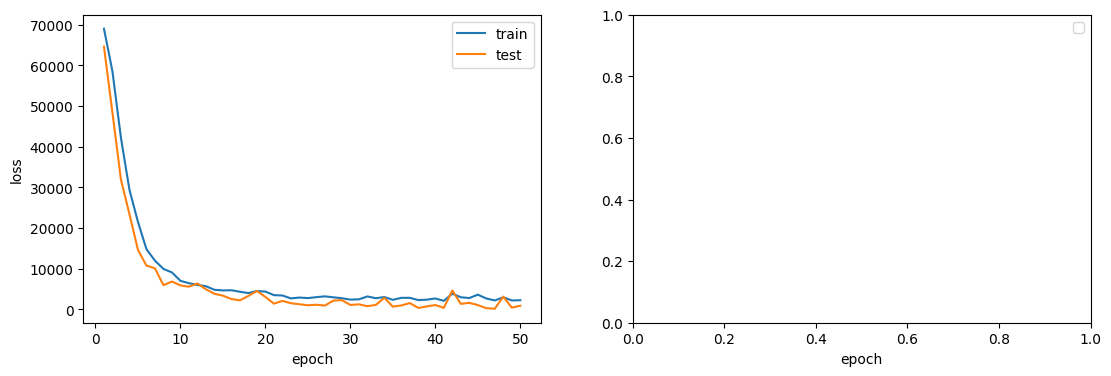

In [53]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

class SGDOptimizer:
    def __init__(self, model, lr=0.01, momentum=0.0):
        self.model = model
        self.lr = lr
        self.momentum = momentum
        self.params = self._flatten(model.getParameters())
        self.velocities = [np.zeros_like(p) for p in self.params]

    def _flatten(self, params):
        flat = []
        for item in params:
            if isinstance(item, (list, tuple)):
                flat.extend(self._flatten(item))
            elif isinstance(item, np.ndarray):
                flat.append(item)
            else:
                raise ValueError(f"Неподдерживаемый тип: {type(item)}")
        return flat

    def step(self):
        grads = self._flatten(self.model.getGradParameters())

        for i in range(len(self.params)):
            self.velocities[i] = self.momentum * self.velocities[i] - self.lr * grads[i]
            self.params[i][...] += self.velocities[i]

class LRScheduler:
    def __init__(self, optimizer, patience=5, factor=0.1, min_lr=1e-6):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                new_lr = max(self.optimizer.lr * self.factor, self.min_lr)
                if new_lr < self.optimizer.lr:
                    self.optimizer.lr = new_lr
                    print(f"Learning rate reduced to {self.optimizer.lr}")
                self.counter = 0

# Генерация данных
n_samples = 1000
n_features = 10
n_targets = 2
noise = 0.2
X, y = make_regression(n_samples=n_samples, n_features=n_features, n_targets=n_targets, noise=noise)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=128, lr=0.001):
    criterion = MSECriterion()
    optimizer = SGDOptimizer(model, lr=lr)
    lr_scheduler = LRScheduler(optimizer)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        permutation = np.random.permutation(len(X_train))
        batch_losses = []

        for i in range(0, len(X_train), batch_size):
            indices = permutation[i:i+batch_size]
            X_batch = X_train[indices]
            y_batch = y_train[indices]
            output = model.forward(X_batch)
            loss = criterion.forward(output, y_batch)
            grad = criterion.backward(output, y_batch)
            model.backward(X_batch, grad)
            optimizer.step()
            model.zeroGradParameters()
            batch_losses.append(loss)

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)
        model.evaluate()
        val_output = model.forward(X_val)
        val_loss = criterion.forward(val_output, y_val)
        val_losses.append(val_loss)

        lr_scheduler.step(val_loss)
        if epoch % 10 == 0:
          print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    plot_losses(train_losses, val_losses)
    return train_losses, val_losses

# Создание и обучение модели
raz = Sequential()
raz.add(Linear(n_features, 128))
raz.add(BatchNormalization())
raz.add(ReLU())
raz.add(Dropout(p=0.5))
raz.add(Linear(128, n_targets))

train_losses, val_losses = train_model(
    model=raz,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=50,
    lr=0.001
)

raz.evaluate()
test_pred = raz.forward(X_test)
small_test_loss = MSECriterion().forward(test_pred, y_test)

<ipython-input-45-529b9eb37fba>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


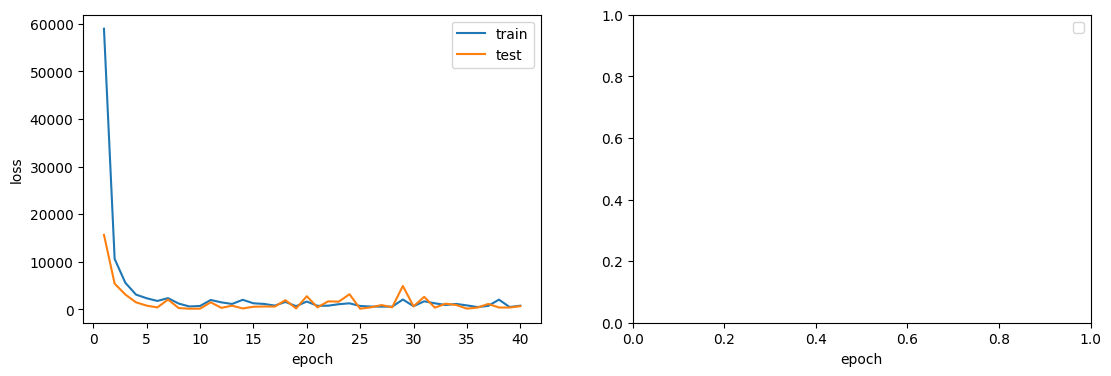

In [76]:
dva = Sequential()
dva.add(Linear(n_features, 256))
dva.add(BatchNormalization())
dva.add(ELU())
dva.add(Dropout(p=0.2))
dva.add(Linear(256, 128))
dva.add(BatchNormalization())
dva.add(ReLU())
dva.add(Linear(128, n_targets))

train_losses, val_losses = train_model(
    model=dva,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=40,
    lr=0.01
)

dva.evaluate()
test_pred = dva.forward(X_test)
medium_test_loss = MSECriterion().forward(test_pred, y_test)

<ipython-input-45-529b9eb37fba>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


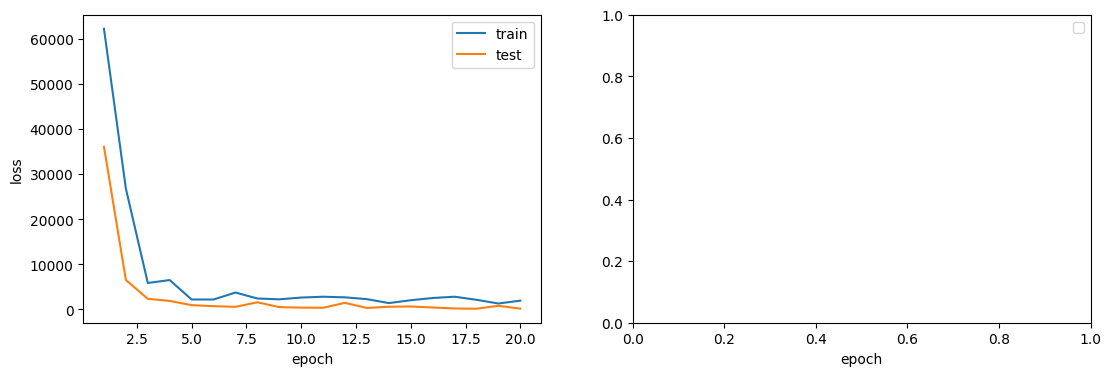


Test Results: MSE = 180.6143, R2 = 0.9974


In [68]:
tri = Sequential()
tri.add(Linear(n_features, 256))
tri.add(BatchNormalization())
tri.add(ReLU())
tri.add(Dropout(p=0.2))
tri.add(Linear(256, 128))
tri.add(BatchNormalization())
tri.add(Gelu())
tri.add(Linear(128, 64))
tri.add(BatchNormalization())
tri.add(ReLU())
tri.add(Linear(64, n_targets))

train_losses, val_losses = train_model(
    model=tri,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=20,
    lr=0.05
)

tri.evaluate()
test_pred = tri.forward(X_test)
large_test_loss = MSECriterion().forward(test_pred, y_test)
r2 = r2_score(y_test, test_pred)
print(f"\nTest Results: MSE = {large_test_loss:.4f}, R2 = {r2:.4f}")

In [78]:
def mnist(input_channels, num_classes):
    model = Sequential()
    model.add(Conv2d())
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2d())
    return model
criterion = ClassNLLCriterion()

In [69]:
train_losses, train_acc = [], []
test_losses, test_acc = [], []

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset, _ = torch.utils.data.random_split(full_trainset, [1000, len(full_trainset) - 1000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = 0.0, 0.0

    model.train()
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()
        logits = model(Flatten(X_batch, start_dim=1))
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.shape[0]

        predictions = torch.argmax(logits, dim=-1)
        train_accuracy += (predictions == y_batch).sum().item()

    n_train = len(train_loader.dataset)
    train_loss /= n_train
    train_losses.append(train_loss)

    train_accuracy /= n_train
    train_acc.append(train_accuracy)

    test_loss, test_accuracy = 0.0, 0.0

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:

            logits = model(Flatten(X_batch, start_dim=1))
            loss = criterion(logits, y_batch)

            test_loss += loss.item() * X_batch.shape[0]

            predictions = torch.argmax(logits, dim=-1)
            test_accuracy += (predictions == y_batch).sum().item()

    n_test = len(test_loader.dataset)
    test_loss /= n_test
    test_losses.append(test_loss)

    test_accuracy /= n_test
    test_acc.append(test_accuracy)

    plot_losses(train_losses, test_losses, train_acc, test_acc)

NameError: name 'transforms' is not defined